In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = np.arange(12)

lags = 3

m = np.zeros((lags+1, len(x) - lags))
print(m.shape)

m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

m

(4, 9)


array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])

Steps:

1) Model Selection: a model is to be picked and instantiated
2) Model fitting: the model is to be fitted to the data at hand
3) Prediction: given the fitted model, the prediction is conducted

In [2]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

lm.fit(m[:lags].T, m[lags])  # first three rows are the training examples, each row is a feature, the 4th row is the target output

LinearRegression()

In [3]:
print(lm.coef_)
print(lm.intercept_)

lm.predict(m[:lags].T)

[0.33333333 0.33333333 0.33333333]
2.0


array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

## Simple Classification Problem
### Logistic Regression

A financial market classification problem relates to predicting the direction of tomorrow's market. The categories are limited to up and down (1, -1) and consolidation, 0. 

Predicting stock returns is an estimation problem rather than a classification problem.

In [4]:
hours = np.arange(0.5, 5.5, 0.25)
success = np.array([0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1])


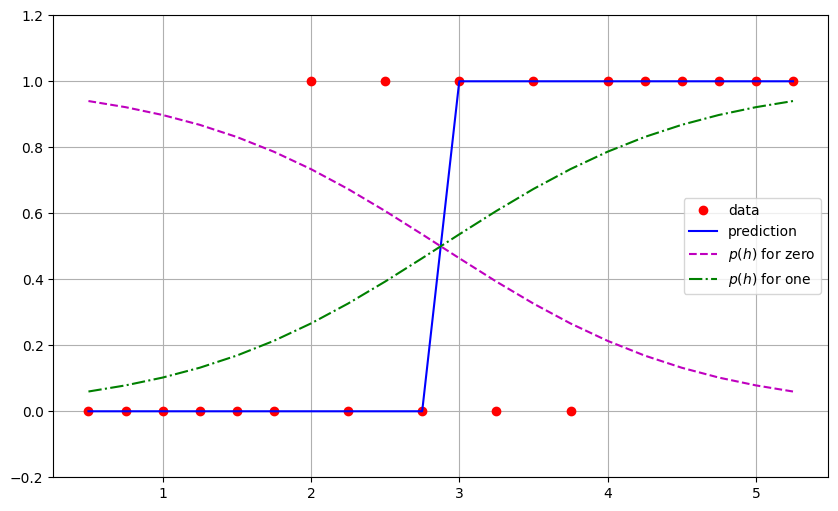

In [5]:
lm = linear_model.LogisticRegression(solver='lbfgs')
hrs = hours.reshape(1, -1).T
lm.fit(hrs, success)
prediction = lm.predict(hrs)

prob = lm.predict_proba(hrs)
plt.figure(figsize=(10,6))
plt.plot(hours, success, 'ro', label = 'data')
plt.plot(hours, prediction, 'b', label = 'prediction')
plt.plot(hours, prob.T[0], 'm--', label = '$p(h)$ for zero')
plt.plot(hours, prob.T[1], 'g-.', label = '$p(h)$ for one')
plt.legend(loc = 0)
plt.ylim(-0.2, 1.2)
plt.grid()
plt.show()






# Market Returns Classification Problem

In [6]:
# We are using the lagged values as the features, m = 3.

# Binary classification problem up 1 or down -1

raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col = 0 , parse_dates=True).dropna()

symbol = 'GLD'

data = pd.DataFrame(raw[symbol])

data.rename(columns= {symbol: 'price'}, inplace = True)

data['return'] = np.log(data['price'] / data['price'].shift(1))

data.dropna(inplace = True)

lags = 3

cols = []

for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)

data.dropna(inplace = True)
data.head(5)

,price,return,lag_1,lag_2,lag_3
Date,,,,,
2010-01-08,111.37,0.004951,-0.006207,0.016365,-0.000911
2010-01-11,112.85,0.013202,0.004951,-0.006207,0.016365
2010-01-12,110.49,-0.021134,0.013202,0.004951,-0.006207
2010-01-13,111.54,0.009458,-0.021134,0.013202,0.004951
2010-01-14,112.03,0.004383,0.009458,-0.021134,0.013202


In [7]:
from sklearn.metrics import accuracy_score

lm = linear_model.LogisticRegression(C= 1e7, solver = 'lbfgs' , max_iter= 1000) # specify model

lm.fit(data[cols], np.sign(data['return'])) # fit data / gradient descent on training set

data['prediction'] = lm.predict(data[cols]) # predict on test set

data['prediction'].value_counts()

hits = np.sign(data['return'].iloc[lags:] * data['prediction'].iloc[lags:]).value_counts()  # since we predict the price at time t based on the lags of t we can check to see if the prediction is right based on whether the sign of the product is + or -

hits

 1.0    1344
-1.0    1153
 0.0      12
Name: count, dtype: int64

In [8]:
accuracy_score(data['prediction'], np.sign(data['return']))

# 53.3% accuracy

0.5362261146496815

return      1.289478
strategy    2.469257
dtype: float64


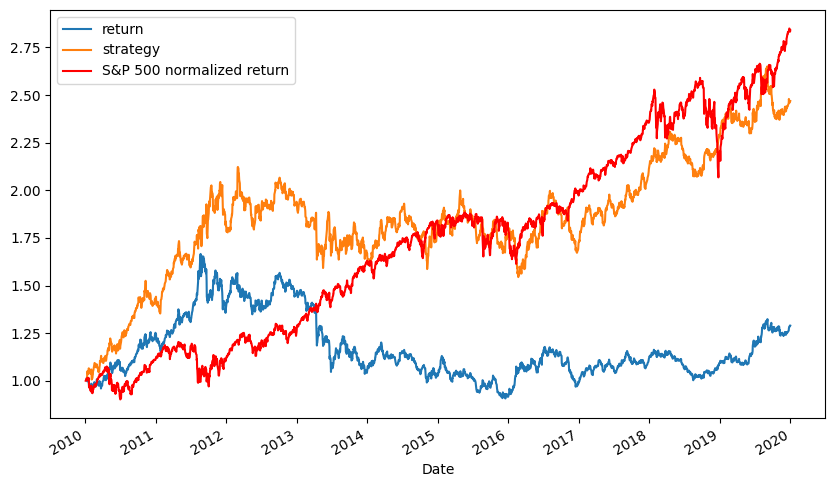

In [9]:
data['strategy'] = data['prediction'] * data['return']

print(data[['return', 'strategy']].sum().apply(np.exp))

data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

normalised_spy = raw['SPY'] / raw['SPY'].iloc[0]
plt.plot(normalised_spy, color = 'red', label = 'S&P 500 normalized return')
plt.legend()
plt.show()

## Using Deep Learning for Market Movement Prediction

In [10]:
# For the test example

data = pd.DataFrame({'hours': hours,
                     'success': success})


In [11]:
from sklearn.neural_network import MLPClassifier

# Multi Later Perceptron, dense neural network

model = MLPClassifier(hidden_layer_sizes= [32], max_iter= 1000, random_state=100)

In [12]:
model.fit(data['hours'].values.reshape(-1,1), data['success'])

data['prediction'] = model.predict(data['hours'].values.reshape(-1,1))

data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.25,1,1


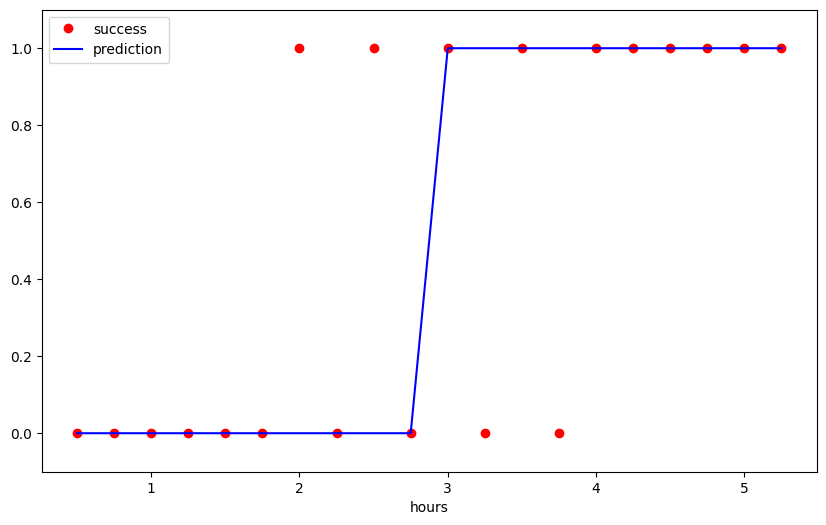

In [13]:
data.plot(x = 'hours', y = ['success', 'prediction'], style = ['ro', 'b-'], ylim = [-.1, 1.1], figsize= (10,6))
plt.show()

## Using Deep Neural Networks to Predict Market Direction


In [14]:
# Retreival of data

symbol = 'EUR='

data = pd.DataFrame(raw[symbol])

data.rename(columns = {symbol: 'price'}, inplace = True)

data['return'] = np.log(data['price']/ data['price'].shift(1))

data['direction'] = np.where(data['return'] > 0, 1, 0)

lags = 5

cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace = True)

data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


Using the Keras Package to apply Deep Neural Network. We define the lags as feature columns, and label and fit the classifier. 

In [15]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

In [16]:
optimizer = Adam(learning_rate=0.0001)

import random

def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

set_seeds()

model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (lags,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(optimizer = optimizer , loss = 'binary_crossentropy', metrics = ['accuracy'])

cutoff = '2017-12-31'

training_data = data[data.index < cutoff].copy()

mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu) / std # normalisation of features by gaussian normalisation 

test_data = data[data.index >= cutoff].copy()

test_data_ = (test_data - mu) / std


model.fit(training_data[cols], training_data['direction'], epochs = 50 , verbose = False, validation_split =  0.2, shuffle = False)


c:\Users\George Bresnahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Axes: >

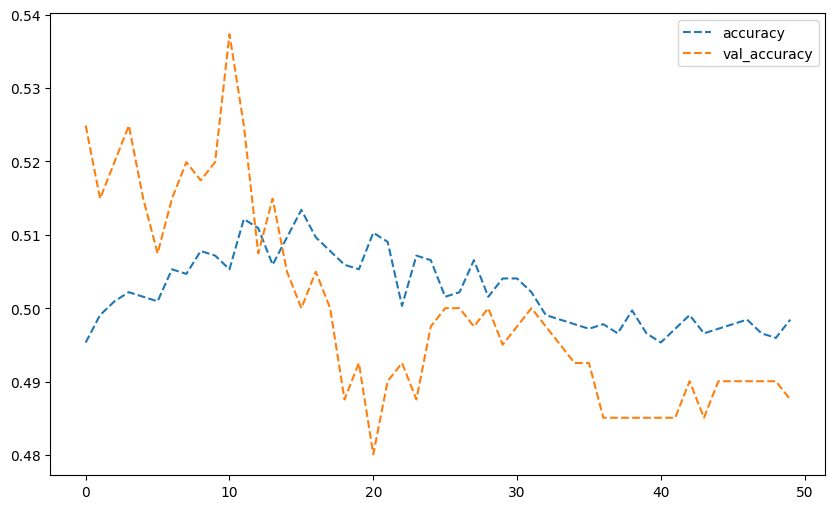

In [17]:
res = pd.DataFrame(model.history.history)


res[['accuracy', 'val_accuracy']].plot(figsize = (10,6), style = '--')

In [18]:
model.evaluate(training_data[cols], training_data['direction'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5195 - loss: 0.6925


[0.6927652955055237, 0.5092177391052246]

In [19]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0) # predicts market direction in sample

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
pred[:30].flatten()

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
training_data['prediction'] = np.where(pred> 0, 1, -1)

In [22]:
training_data['strategy'] = (training_data['prediction'] * training_data['return'])
                             
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    1.074617
dtype: float64

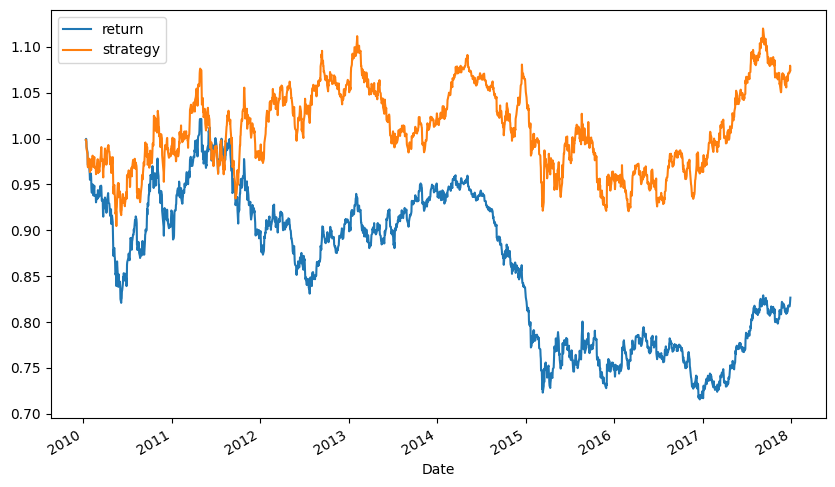

In [23]:
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()

In [24]:
# How does it perform on the test set

model.evaluate(test_data_[cols], test_data['direction'])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4755 - loss: 0.7952


[0.7941958904266357, 0.4572564661502838]

In [25]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1 , 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)

test_data['prediction'].value_counts()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


prediction
 1    403
-1    100
Name: count, dtype: int64

In [26]:
test_data['strategy'] = (test_data['prediction'] * test_data['return'])

test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.880805
dtype: float64

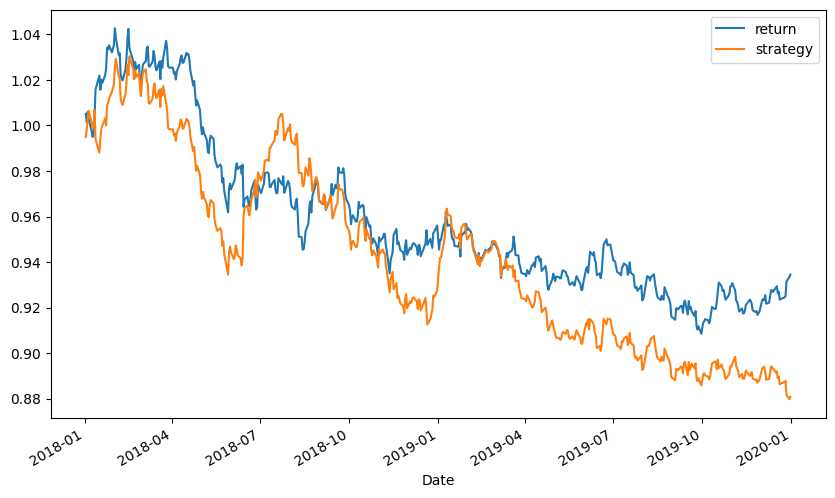

In [27]:
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize= (10,6))
plt.show()

The strategy performs worse on the test set than the training set and the base instrument outperforms the machine learning strategy. 

Some possible reasons for this are market anomalies influencing predictive power such as the Eurozone crisis of 2012. The training set data is thus unlikely valid.

### Adding different types of features

So far the features have only been lagged returns, however we can use other technical anlaysis features such as momentum, volatility or distance measures, these are the measures suggested by the author.

In [28]:
data['momentum'] = data['return'].rolling(5).mean().shift(1) # momentum based feature 

data['volatility'] = data['return'].rolling(20).std().shift(1) # volatility based feature

data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1) # distance based feature

data.dropna(inplace = True)

cols.extend(['momentum', 'volatility', 'distance'])

print(data.round(4).tail())



             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [30]:
training_data = data[data.index < cutoff].copy()

mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu) / std # normalisation of features by gaussian normalisation 

test_data = data[data.index >= cutoff].copy()

test_data_ = (test_data - mu) / std


set_seeds()
optimizer = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(training_data_[cols], training_data['direction'],
          verbose=True, epochs=25)

Epoch 1/25


c:\Users\George Bresnahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5132 - loss: 0.7238
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5164 - loss: 0.7123
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5166 - loss: 0.7053
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5155 - loss: 0.7007
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5130 - loss: 0.6976
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5166 - loss: 0.6954
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 0.6937
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5315 - loss: 0.6924
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5339 - loss: 0.6914
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5244 - loss: 0.6905
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5284 - loss: 0.6897
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5372 - loss: 0.6890


In [31]:
model.evaluate(training_data_[cols], training_data['direction'])

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5392 - loss: 0.6860


[0.6852320432662964, 0.5426673293113708]

In [35]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

training_data['prediction'] = np.where(pred > 0, 1, -1)

training_data['strategy'] = (training_data['prediction'] * training_data['return'])

training_data[['return', 'strategy']].sum().apply(np.exp)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


return      0.901074
strategy    2.483560
dtype: float64

<Axes: xlabel='Date'>

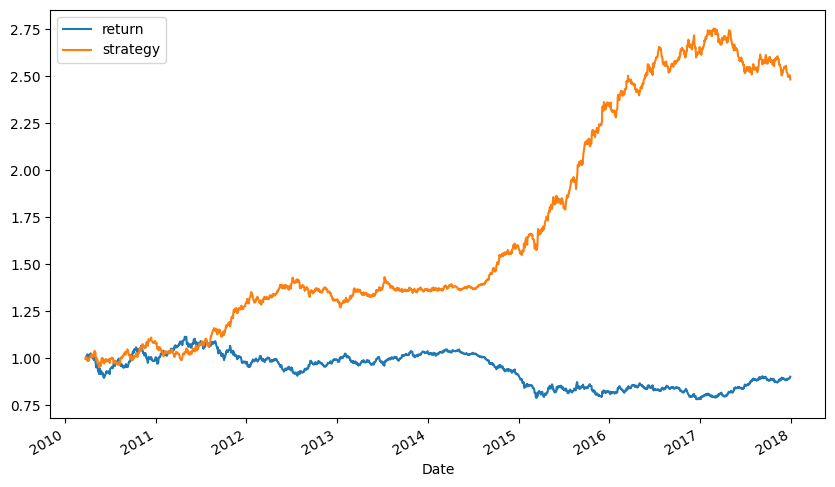

In [ ]:
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# evaluation over training set

In [37]:
# evaluation over test set

model.evaluate(test_data_[cols], test_data['direction'])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5192 - loss: 0.6924 


[0.6920908689498901, 0.5188866853713989]

In [38]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred> 0 , 1, -1)

test_data['prediction'].value_counts()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


prediction
-1    361
 1    142
Name: count, dtype: int64

In [39]:
test_data['strategy'] = (test_data['prediction']* test_data['return'])

test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.135347
dtype: float64

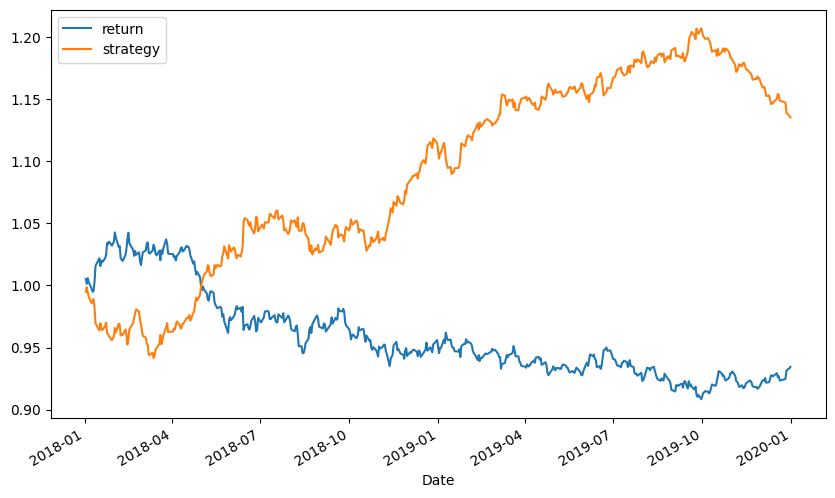

In [41]:
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()

The above graph shows the performance of the EUR/USD compared to the deep learning-based strategy which is out of sample using additional features.

This is a trivial approach and I have worked through this, simply, to implement the concepts from Stanfords Machine Learning specialization to algorithmic trading, at an beginners level.